# UK Energy demand forecast

In [1]:
import numpy as np
import pandas as pd
from numpy import arange

# importing matplotlib module
import matplotlib.pyplot as plt
plt.style.use('default')

from matplotlib import pyplot
  
# %matplotlib inline: only draw static images in the notebook
%matplotlib inline

import seaborn as sns
import matplotlib.ticker as ticker

from scipy.optimize import curve_fit

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics

from statsmodels.tsa.seasonal import seasonal_decompose

# ln -sf /usr/lib/x86_64-linux-gnu/libstdc++.so.6 /home/zozodev/anaconda3/envs/dmcgb/bin/../lib/libstdc++.so.6

/home/zozodev/anaconda3/envs/python3_10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading energy demand data

In [2]:
energy_df = pd.read_csv('../data/energy.dat', parse_dates = ['Date'])
energy_df.columns = ['date', 'consumption']

display(energy_df)

,date,consumption
0,2015-04-01,357.073
1,2015-04-02,341.931
2,2015-04-03,318.777
3,2015-04-04,312.494
4,2015-04-05,270.837
...,...,...
1822,2020-03-27,237.171
1823,2020-03-28,229.744
1824,2020-03-29,297.636
1825,2020-03-30,323.811


In [3]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1827 non-null   datetime64[ns]
 1   consumption  1827 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.7 KB


### Features identification
We have the date and consumption volume as variables

## Setting forecasting period

In [4]:
timestamps_forecast_df = energy_df[ (energy_df['date'] > '2018-03-31') & (energy_df['date'] < '2019-04-01') ]
timestamps_forecast_df['date'] = timestamps_forecast_df['date'].apply(lambda x: x.replace(year = x.year + 2))

timestamps_forecast_df

/tmp/ipykernel_19052/2667224419.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamps_forecast_df['date'] = timestamps_forecast_df['date'].apply(lambda x: x.replace(year = x.year + 2))


,date,consumption
1096,2020-04-01,290.177
1097,2020-04-02,291.881
1098,2020-04-03,222.948
1099,2020-04-04,254.333
1100,2020-04-05,285.250
...,...,...
1456,2021-03-27,271.052
1457,2021-03-28,273.063
1458,2021-03-29,223.733
1459,2021-03-30,184.989


## Plotting energy data

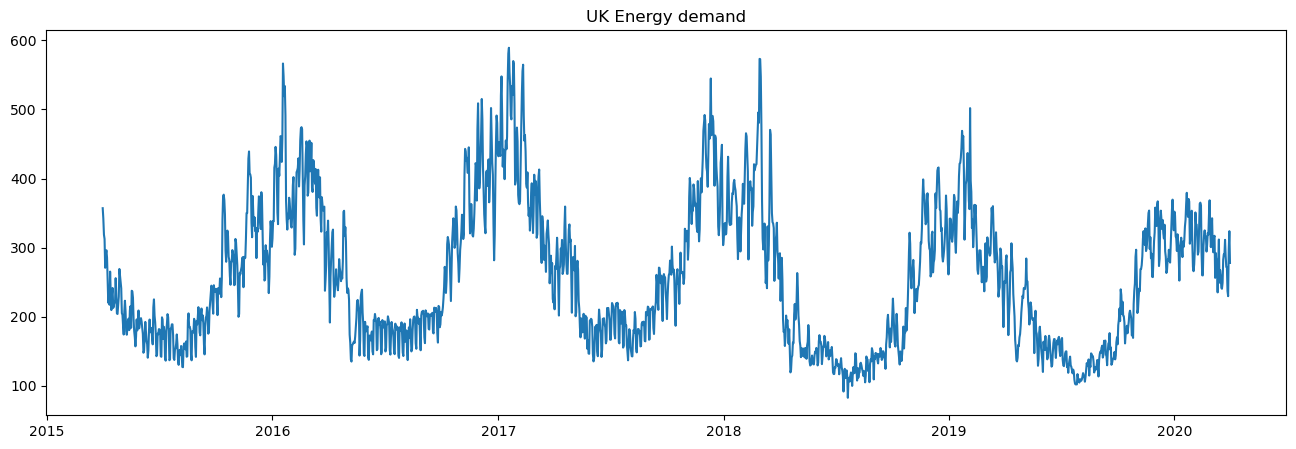

In [5]:
# plot input vs output
plt.figure(figsize=(16, 5))
plt.title(f"UK Energy demand")

pyplot.plot(energy_df['date'], energy_df['consumption'])

## Decomposing demand data in a seasonal pattern structure

We use a multiplicative model to extract and decompose general trend from seasonal pattern

As appears in the graph, we use 365 days period.

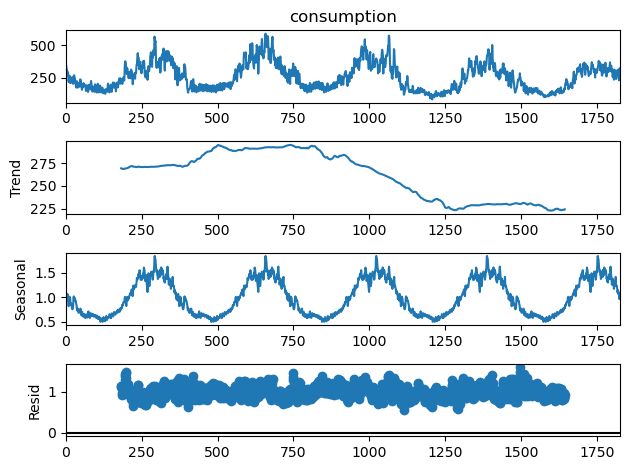

<Figure size 5000x2000 with 0 Axes>

In [6]:
period = 365
curve_decomp = seasonal_decompose(energy_df['consumption'], model='multiplicative', period=period)
 
curve_decomp.plot()
pyplot.figure(figsize=(50,20))
pyplot.show()

## Forecasting for a period pattern of 365 days

We can see a very unusual decreasing global trend. Without additional information we will use 3 hypothetic future trend Increasing, stagnant, decreasing.

In [7]:
trend = [v for v in curve_decomp.trend]
last_value = [v for v in trend if not np.isnan(v)][-1]
last_value

new_trend = trend.copy()
for i in range(1, len(new_trend)):
    if np.isnan(new_trend[-i]):
        new_trend[-i] = last_value
    else:
        break

forecast_period = 366
max_trend = np.nanmax(new_trend)
steps = (max_trend - last_value)*2/3/forecast_period
forecast_trend_1 = [last_value + i*steps for i in range(1, forecast_period)]
forecast_trend_2 = [last_value] * (forecast_period - 1)
forecast_trend_3 = [last_value - i*steps/2 for i in range(1, forecast_period)]

consumption_forecast_2020_1 = forecast_trend_1 * curve_decomp.seasonal[:forecast_period-1]
consumption_forecast_2020_2 = forecast_trend_2 * curve_decomp.seasonal[:forecast_period-1]
consumption_forecast_2020_3 = forecast_trend_3 * curve_decomp.seasonal[:forecast_period-1]

## Plotting of the forecasts

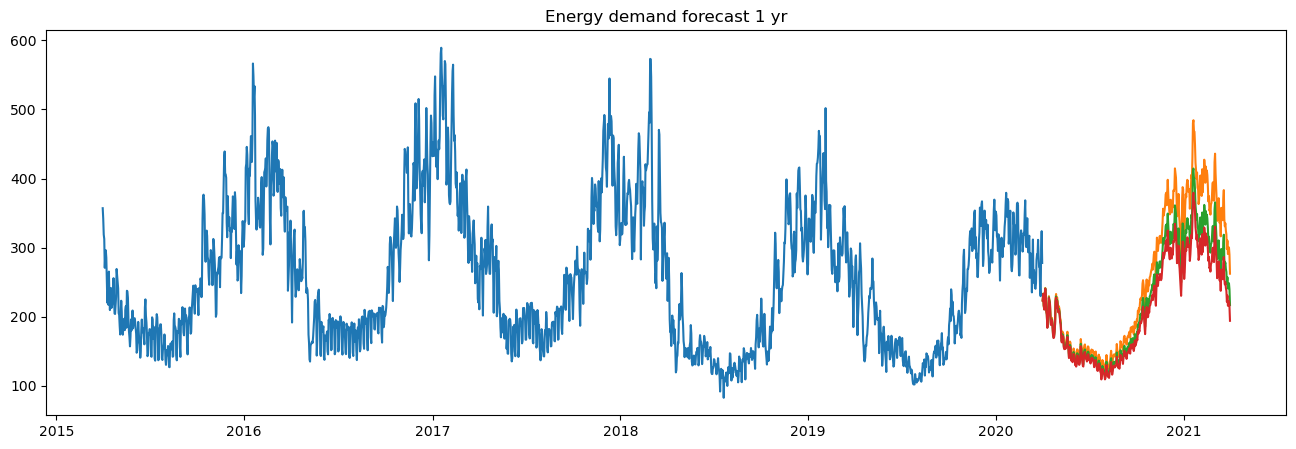

In [8]:
# plot input vs output
plt.figure(figsize=(16, 5))
plt.title("Energy demand forecast 1 yr")

pyplot.plot(energy_df['date'], energy_df['consumption'])
pyplot.plot(timestamps_forecast_df['date'], consumption_forecast_2020_1)
pyplot.plot(timestamps_forecast_df['date'], consumption_forecast_2020_2)
pyplot.plot(timestamps_forecast_df['date'], consumption_forecast_2020_3)

pyplot.show()
plt.close()

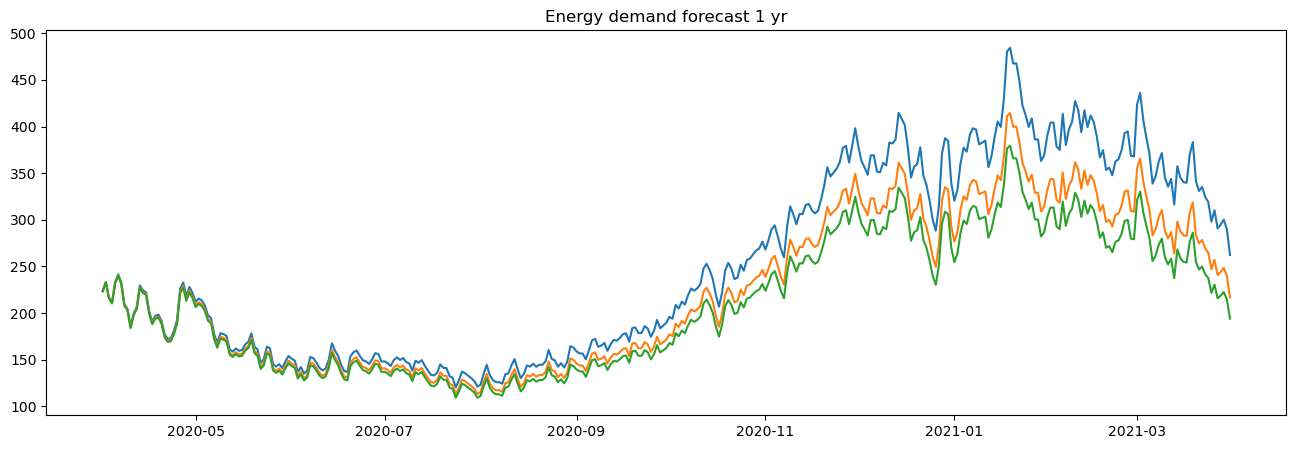

In [9]:
plt.figure(figsize=(16, 5))
plt.title("Energy demand forecast 1 yr")

pyplot.plot(timestamps_forecast_df['date'], consumption_forecast_2020_1)
pyplot.plot(timestamps_forecast_df['date'], consumption_forecast_2020_2)
pyplot.plot(timestamps_forecast_df['date'], consumption_forecast_2020_3)

pyplot.show()
plt.close()

## Comments
This is a very basic energy demand model. We have used Statmodel for a quick and simple analysis. However, there are numerous other modeling tools more or less sophisticated.

In order to refine one's analysis, we would need to know the time frame. Whether we are interested in a micro or near short term, medium term, or long term time scale.

Also, the model could be further refined by included key variables, such as GDP, macro and micro economy, key industries production forecast, weather, ...

International and geographical aspect could also be taken into account